# Command: A new tool for building multi-agent architectures in LangGraph


Building agentic and multi-agent systems is all about communication.

Now, nodes can dynamically decide which node to execute next, improving flexibility and simplifying complex workflows.

#### **What's New:**
- **Edgeless graphs:** Nodes no longer need edges to connect. Instead, they can directly specify which node to go to next, making your agent flows more intuitive and adaptable.

- **Enhanced control:** Control the flow after the state update by returning a Command that points to the next node, enabling dynamic, real-time decision-making.

In [1]:
%%capture --no-stderr
%pip install -U langgraph

Let's learn it with a simple example - An
AI-powered home search engine like: https://flyhomes.com/.


In [16]:
import random
from typing import Annotated, TypedDict, Literal, Optional

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# This is new
from langgraph.types import Command

## S1: Understand Command Basic Usage

In [25]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]

In [26]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # THis is where llm decides which node shall I go next
    value = random.choice(["search_nearby_homes", "answer_question"])

    # This is a replacement for a conditional edge function
    if value == "search_nearby_homes":
        goto = "search_nearby_homes"
    else:
        goto = "answer_question"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is a replacement for an edge
        goto=goto,
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    return {"messages": [AIMessage(content="System is down - please try later")]}

In [27]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

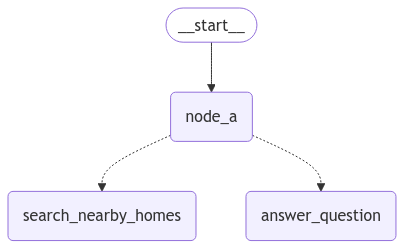

In [28]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called answer_question

[FINAL RESPONSE]
 {'address': 'Karachi', 'messages': [AIMessage(content='System is down - please try later', additional_kwargs={}, response_metadata={}, id='fe470f7e-fa75-4b20-b584-b116735ad8c0')]}


## S2: Update State using Command

After node_1 we can update our state as well. So if user is already in our system we can add it's user data in the stage to personalize user experience.

In [32]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [39]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # THis is where llm decides which node shall I go next
    value = random.choice(["search_nearby_homes", "answer_question"])

    # This is a replacement for a conditional edge function
    if value == "search_nearby_homes":
        goto = "search_nearby_homes"
    else:
        goto = "answer_question"

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data},
        # this is a replacement for an edge
        goto=goto,
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}

In [40]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

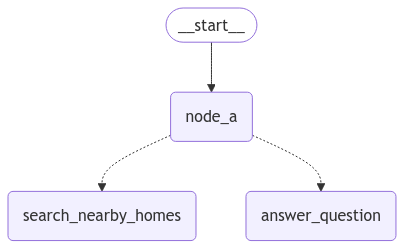

In [41]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called answer_question
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Karachi', 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='28196ff3-8ccb-4e92-850f-07c298251285')], 'user_data': {'name': 'Ammen Alam'}}


# S3: Run Nodes(Agents) in Parallel


Now our user requirement is to both find homes and have conversation with user.
For this:

- We shall call Both Nodes in Parrallel

In [44]:
# Define graph state
class State(TypedDict):
    address: str # address where user wants to search homes for.
    nearby_homes: Optional[list[dict]] # list of nearby homes
    messages: Annotated[list, add_messages]
    user_data: Optional[dict] # user data - for registered users we already have this

In [47]:
# Define the nodes (agents)

def node_a(state: State) -> Command[Literal["search_nearby_homes", "answer_question"]]:
    print("Called A")

    # Get User Data From Memory or Data Store
    fetched_user_data = {"name": "Ammen Alam"}

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={"user_data": fetched_user_data},
        # this is a replacement for an edge
        goto=["search_nearby_homes", "answer_question"],
    )


# Nodes search_nearby_homes and answer_question are unchanged (just like before)
def search_nearby_homes(state: State):
    print("Called search_nearby_homes!")
    print("UserInfo", state["user_data"])
    return {"nearby_homes": [{"home_1": "Zia House"}, {"home_2": "Qasim House"}]}


def answer_question(state: State):
    print("Called answer_question")
    print("UserInfo", state["user_data"])
    user_name = state["user_data"].get("name", "Guest")
    return {"messages": [AIMessage(content=f"Hi, {user_name} Welcome to Homes AI Search Engine")]}

In [48]:
builder = StateGraph(State)
builder.add_edge(START, "node_a")
builder.add_node(node_a)
builder.add_node(search_nearby_homes)
builder.add_node(answer_question)
# NOTE: there are no edges between nodes A, B and C!

graph = builder.compile()

In [49]:
agent_response = graph.invoke({"address": "Karachi"})

print("\n[FINAL RESPONSE]\n", agent_response)

Called A
Called search_nearby_homes!
UserInfo {'name': 'Ammen Alam'}
Called answer_question
UserInfo {'name': 'Ammen Alam'}

[FINAL RESPONSE]
 {'address': 'Karachi', 'nearby_homes': [{'home_1': 'Zia House'}, {'home_2': 'Qasim House'}], 'messages': [AIMessage(content='Hi, Ammen Alam Welcome to Homes AI Search Engine', additional_kwargs={}, response_metadata={}, id='0d234fef-d86b-4d48-8a79-b1347b91ade3')], 'user_data': {'name': 'Ammen Alam'}}


##

## Final Notes


- **Task**: In `node_a` replace that random with an llm and it will decide in which node to go next.

- **Question:** What will happen if two nodes running in parallel try update same key in state (Think about reducers and find your answer in Module 4)

References:
- https://langchain-ai.github.io/langgraph/how-tos/command/#define-graph
- https://blog.langchain.dev/command-a-new-tool-for-multi-agent-architectures-in-langgraph/